# TensorFlow Dataset API

**Learning Objectives**
    - Learn how use tf.datma to read data into TF models
    - Understand difference between loading data entirely in-memory and loading in batches from disk
    - Practice loading a .csv file from disk in batches using the tf.data module



In [1]:
# Ensure that we have Tensorflow 1.13.1 installed.
!pip freeze | grep tf-nightly-2.0-preview || pip install tf-nightly-2.0-preview

tf-nightly-2.0-preview==2.0.0.dev20190906


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [4]:
print(tf.__version__)

2.0.0-dev20190908


## Linear Regression

Now let's use low level tensorflow operations to implement linear regression.

Later in the course you'll see abstracted ways to do this using high level TensorFlow.

### Toy Dataset

We'll model the following function:

\begin{equation}
y= 2x + 10
\end{equation}

In [134]:
N_POINTS = 10
X = tf.constant(range(N_POINTS), dtype=tf.float32)
Y = 2 * X + 10

In [135]:
def create_dataset(X, Y, epochs=5, batch_size=N_POINTS):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [136]:
dataset = create_dataset(X, Y)

In [137]:
for i, (x, y) in enumerate(dataset):
    print("x:", x.numpy(), "y:", y.numpy())

x: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
x: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
x: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
x: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]
x: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] y: [10. 12. 14. 16. 18. 20. 22. 24. 26. 28.]


#### Loss Function

Using mean squared error, our loss function is:
\begin{equation}
MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y}_i-Y_i)^2
\end{equation}

$\hat{Y}$ represents the vector containing our model's predictions:
\begin{equation}
\hat{Y} = w_0X + w_1
\end{equation}

In [138]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

### Gradient Function

To use gradient descent we need to take the partial derivatives of the loss function with respect to each of the weights. We could manually compute the derivatives, but with Tensorflow's automatic differentiation capabilities we don't have to!

During gradient descent we think of the loss as a function of the parameters $w_0$ and $w_1$. Thus, we want to compute the partial derivative with respect to these variables. 

For that we need to wrap our loss computation within the context of `tf.GradientTape` instance which will reccord gradient information:

```python
with tf.GradientTape() as tape:
    loss = # computation 
```

This will allow us to later compute the gradients of any tensor computed within the `tf.GradientTape` context with respect to instances of `tf.Variable`:

```python
gradients = tape.gradient(loss, [w0, w1])
```

We illustrate this procedure with by computing the loss gradients with respect to the model weights:

In [139]:
def compute_gradients(X, Y, w0, w1):
    with tf.GradientTape() as tape:
        loss = loss_mse(X, Y, w0, w1)
    return tape.gradient(loss, [w0, w1])

In [140]:
w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dw0, dw1 = compute_gradients(X, Y, w0, w1)

In [141]:
print("dw0:", dw0.numpy())

dw0: -204.0


In [142]:
print("dw1", dw1.numpy())

dw1 -38.0


### Training Loop

Here we have a very simple training loop that converges. Note we are ignoring best practices like batching, creating a separate test set, and random weight initialization for the sake of simplicity.

In [157]:
STEPS = 1000
BATCH_SIZE = 10
LEARNING_RATE = .02
MSG = "STEP {step} - loss: {loss}, w0: {w0}, w1: {w1}\n"


w0 = tf.Variable(0.0)
w1 = tf.Variable(0.0)

dataset = create_dataset(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE)

for step, (X, Y) in enumerate(dataset):

    dw0, dw1 = compute_gradients(X, Y, w0, w1)
    w0.assign_sub(dw0 * LEARNING_RATE)
    w1.assign_sub(dw1 * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(X, Y, w0, w1)
        print(MSG.format(step=step, loss=loss, w0=w0.numpy(), w1=w1.numpy()))


STEP 0 - loss: 35.70719528198242, w0: 4.079999923706055, w1: 0.7599999904632568

STEP 100 - loss: 2.6017532348632812, w0: 2.4780430793762207, w1: 7.002389907836914

STEP 200 - loss: 0.26831889152526855, w0: 2.153517961502075, w1: 9.037351608276367

STEP 300 - loss: 0.027671903371810913, w0: 2.0493006706237793, w1: 9.690855979919434

STEP 400 - loss: 0.0028539239428937435, w0: 2.0158326625823975, w1: 9.90071964263916

STEP 500 - loss: 0.0002943490108009428, w0: 2.005084753036499, w1: 9.96811580657959

STEP 600 - loss: 3.0356444767676294e-05, w0: 2.0016329288482666, w1: 9.989760398864746

STEP 700 - loss: 3.1322738323069643e-06, w0: 2.0005245208740234, w1: 9.996710777282715

STEP 800 - loss: 3.2238213520940917e-07, w0: 2.0001683235168457, w1: 9.998944282531738

STEP 900 - loss: 3.369950718479231e-08, w0: 2.000054359436035, w1: 9.999658584594727



## Bonus

Try modelling a non-linear function such as: $y=xe^{-x^2}$

In [161]:
X = tf.constant(np.linspace(0, 2, 1000), dtype=tf.float32)
Y = X * tf.exp(-X**2)

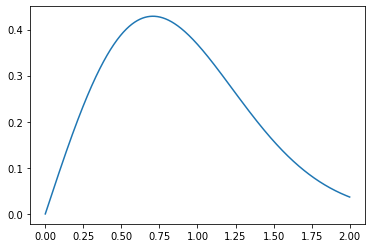

In [162]:
%matplotlib inline

plt.plot(X, Y)

In [185]:
def make_features(X, Y):
    f1 = tf.ones_like(X)  # Bias.
    f2 = X
    f3 = tf.square(X)
    f4 = tf.sqrt(X)
    f5 = tf.exp(X)
    return X, Y
    return tf.stack([f1, f2, f3, f4, f5], axis=1), Y

In [186]:
def create_dataset(X, Y, epochs=5, batch_size=10):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(make_features)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [187]:
dataset = create_dataset(X, Y)

for step, (X, Y) in enumerate(dataset):
    if step > 1: break
    print("STEP", step, "X:", X.numpy(), "Y:", Y.numpy())

STEP 0 X: [0.06006006 0.06206206 0.06406406 0.06606606 0.06806806 0.07007007
 0.07207207 0.07407407 0.07607608 0.07807808] Y: [0.0598438  0.06182348 0.06380167 0.06577833 0.06775342 0.06972688
 0.07169867 0.07366875 0.07563705 0.07760355]
STEP 1 X: [0.06006006 0.06206206 0.06406406 0.06606606 0.06806806 0.07007007
 0.07207207 0.07407407 0.07607608 0.07807808] Y: [0.0598438  0.06182348 0.06380167 0.06577833 0.06775342 0.06972688
 0.07169867 0.07366875 0.07563705 0.07760355]


In [166]:
def predict(X, W):
    return tf.squeeze(X @ W, -1)

In [167]:
def loss_mse(X, Y, W):
    Y_hat = predict(X, W)
    errors = (Y_hat - Y)**2
    return tf.reduce_mean(errors)

In [168]:
def compute_gradients(X, Y, W):
    with tf.GradientTape() as tape:
        loss = loss_mse(Xf, Y, W)
    return tape.gradient(loss, W)

STEP: 2000 MSE: 0.002376794582232833


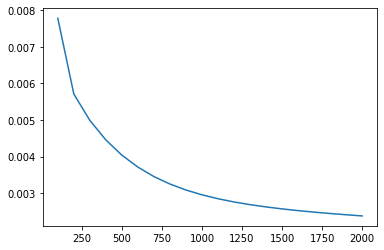

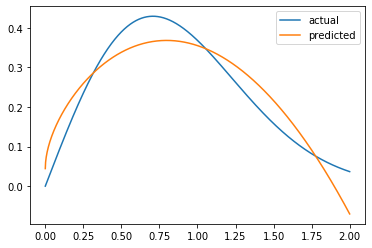

In [207]:
STEPS = 2000
LEARNING_RATE = .02


Xf = make_features(X)
n_weights = Xf.shape[1]

W = tf.Variable(np.zeros((n_weights, 1)), dtype=tf.float32)

# For plotting
steps, losses = [], []
plt.figure()


for step in range(1, STEPS + 1):

    dW = compute_gradients(X, Y, W)
    W.assign_sub(dW * LEARNING_RATE)

    if step % 100 == 0:
        loss = loss_mse(Xf, Y, W)
        steps.append(step)
        losses.append(loss)
        plt.clf()
        plt.plot(steps, losses)


print("STEP: {} MSE: {}".format(STEPS, loss_mse(Xf, Y, W)))

plt.figure()
plt.plot(X, Y, label='actual')
plt.plot(X, predict(Xf, W), label='predicted')
plt.legend()

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License